# Статистика, DS-поток
## Практическое задание 7


**Правила:**

* Дедлайн **26 октября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 7 баллов
* Задача 2 &mdash; 7 баллов
* Задача 3 &mdash; 10 баллов

**Важность задач:**

* *высокая:* задачи 1, 2;
* *обычная:* задача 3.

In [351]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

__________________
## Задача 1.

Пусть $X_1, ..., X_n$ &mdash; выборка из условного распределения $\mathcal{N}(\theta, \sigma^2)$, $\theta \in \Theta = \mathbb{R}$ и $\theta$ в качестве априорного распределения имеет стандартное распределение Коши со сдвигом. 

Апостериорное распределение вычисляется по формуле:
$$q\left.(t\,\right|\,x) = \frac {q(t) p_t(x_1) ... p_t(x_n)} {\int\limits_\Theta q(t) p_t(x_1) ... p_t(x_n) dt},$$ 
где $p_t(x)$ &mdash; плотность распределения $\mathcal{N}(t, \sigma^2)$, а $q(t)$ &mdash; плотность распределения Коши.
Как было сказано на лекции, аналитически интеграл в знаменателе посчитать не удастся. Однако, этот интеграл можно вычислить численно, например, с помощью метода Монте-Карло.

В данном случае, интеграл $\int\limits_{\mathbb{R}} f(x) p(x) dx$, где $p(x)$ &mdash; некоторая плотность, можно оценить как  $\frac{1}{k}\sum\limits_{j=1}^k f(\xi_i)$, где $\xi_1, ..., \xi_k$ &mdash; сгенерированная выборка из распределения, имеющего плотность $p(x)$.

Рассмотрим столбец Alcalinity of ash датасета <a href="http://archive.ics.uci.edu/ml/datasets/Wine">о вине</a>. Постройте гистограмму этого признака. Похоже ли, что наше предпложение о его распределении верно?

Выберите параметры априорного распределения некоторым разумным способом, не опираясь на данные. Для этого рекомендуется поискать  информацию в других источниках и по ней сделать предположение о параметрах априорного распределения и $\sigma$. Объясните свой выбор. 

Для выборки, образованной столбцом Alcalinity of ash, посчитайте $c$ &mdash; знаменатель в формуле Байеса. Рассмотрите два подхода:

1. Посчитать исходный интеграл напрямую методом Монте-Карло.

2. Вычислить интеграл в знаменателе апостериорной плотности без учета константы нормального распределения, то есть посчитать следующий интеграл:
$$
\int\limits_\Theta q(t) \prod_{i=1}^n \widetilde{p}_t(x_i)dt,
$$
где $$\widetilde{p}_t(x) = \exp\left({-\frac{\left(x - t\right)^2}{2\sigma^2}}\right)$$
Константа из нормального распределения встречается и в числителе, поэтому, при подчете апостериорной плотности, мы можем ее заранее сократить.

Какой размер вспомогательной выборки в методе приближенного интегрирования необходим, чтобы с большой точностью посчитать значение $c$? 

Попробуйте применить оба описанных подхода. Выберите лучший и объясните свой выбор.

**Решение:**

In [603]:
names=['Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols',
       'Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
data = pd.read_csv('wine.data',names=names)
data= data.reset_index()
data=data.rename(columns={'index':'wine grade'})
data=data[["Alcalinity of ash"]]
data.head()

,Alcalinity of ash
0,15.6
1,11.2
2,18.6
3,16.8
4,21.0


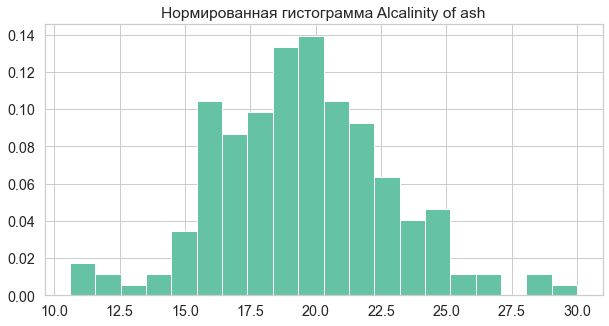

In [604]:
grid = np.linspace(0, 12, 100)
plt.figure(figsize=(10, 5))
plt.hist(data, bins=20, density=True)
plt.title('Нормированная гистограмма Alcalinity of ash');

Давайте для начала объясню, как я выбрал $\sigma$ и $\theta$(смещение в распределении Коши). Для этого я решил изучить, что это за компонента в вине, на русском это называется щелочность золы. В статье пишется, что ее показатели колеблются в диапазоне между (10.52,39.96)([сама статья](http://aas.bf.uni-lj.si/september2003/11kosmerl.pdf)). Давайте возьмем среднюю оценку равную a=25.24. Также в статье расписаны стандартные отклонения при множестве экспериментов, так что за примерное стандартное отклонение можно взять их, оно равно 3.26. Также можно другим способом определить $\sigma$, а точнее с помощью правила трех сигм, так как мы знаем диапазон значений и знаем, что оно описывается нормальным распределением(смотрели в пред. дз+гистограмма сверху)

In [605]:
df=data.to_numpy()

In [636]:
#теперь давайте подсчитаем знаменатель (интеграл) двумя способами
sigma=3.26
loc_cauchy=25.24
size_add_selection=10**5
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)

#1 способ

c_1=np.mean(np.prod((sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
c_1

1.0643176260387176e-205

In [637]:
#теперь 2 способ
const=np.sqrt(2*np.pi)*sigma #вынесем константу вне интеграла

c_2=np.mean(np.prod(const*(sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
c_2

2.617051990691781e-43

*Давайте посмотрим как размер доп выборки влияет на точность вычисления интеграла*

In [643]:
size_list=np.arange(100,10**5,100)
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)
c_2=[]
for i in tqdm(range(len(size_list))):
    c_2.append(np.mean(np.prod(const*(sps.norm(loc=ksi[:size_list[i]], scale=sigma).pdf(df)),axis=0)))

  0%|          | 0/999 [00:00<?, ?it/s]

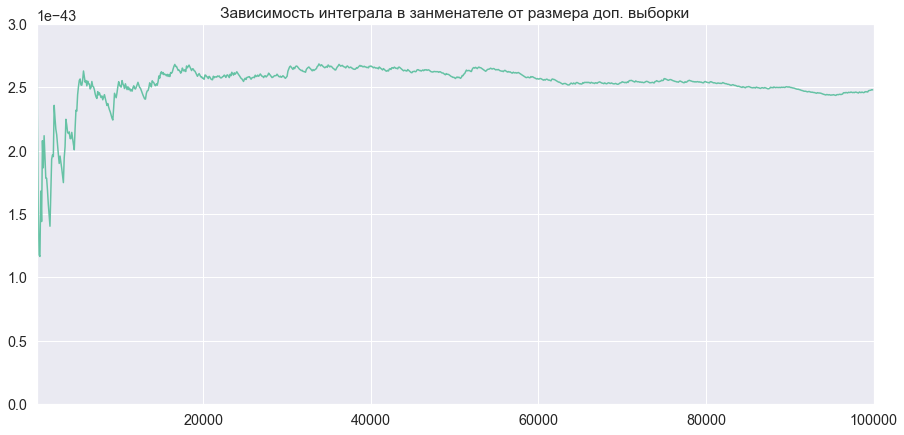

In [651]:
plt.figure(figsize=(15, 7))
plt.plot(size_list,c_2)
plt.title('Зависимость интеграла в занменателе от размера доп. выборки')
plt.xlim(100,10**5);
plt.ylim(0,3e-43);

Хорошо видно, что знаменатель почти не меняется при размере выборки 2e4.

*Давайте узнаем*, что будет, если мы возьмем неправильное распределение Коши с не тем сдвигом, возьмем например 0 и 50

In [628]:
loc_cauchy=50
sigma=3.26
size_add_selection=10**5
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)
c_2=np.mean(np.prod(const*(sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
print('c_2 при сдвиге в Коши=50 равен',c_2)

loc_cauchy=0
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)
c_2=np.mean(np.prod(const*(sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
print('c_2 при сдвиге в Коши=0 равен',c_2)

#давайте поменяем сигму еще на 10
sigma=5

loc_cauchy=50
size_add_selection=10**5
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)
c_1=np.mean(np.prod((sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
c_2=np.mean(np.prod(const*(sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
print('c_2 при сдвиге в Коши=50 равен с сигмой=10',c_2)
print('c_1 при сдвиге в Коши=50 равен с сигмой=10',c_1)

loc_cauchy=0
ksi=sps.cauchy(loc=loc_cauchy).rvs(size=size_add_selection)
c_1=np.mean(np.prod((sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
c_2=np.mean(np.prod(const*(sps.norm(loc=ksi, scale=sigma).pdf(df)),axis=0))
print('c_2 при сдвиге в Коши=0 равен с сигмой=10',c_2)
print('c_1 при сдвиге в Коши=0 равен с сигмой=10',c_1)

c_2 при сдвиге в Коши=50 равен 7.089577027411935e-45
c_2 при сдвиге в Коши=0 равен 2.792111205285602e-44
c_2 при сдвиге в Коши=50 равен с сигмой=10 2.5432389980871327e-54
c_1 при сдвиге в Коши=50 равен с сигмой=10 1.0342989373236242e-216
c_2 при сдвиге в Коши=0 равен с сигмой=10 5.026479405067048e-54
c_1 при сдвиге в Коши=0 равен с сигмой=10 2.0441973055030244e-216


Видно, что неправильный выбор параметра Коши спокойно на несколько разрядов уменьшает правильность нашего интеграла, но что еще более плохое, то что неправильный выбор $\sigma$ при довольно большом размере выборки способно обнулить c_2 и уже почти обнуляет c_1(была бы выборка на значений 20 больше, c_1 обнулилось бы)

2 способ имеет огромное преимущество перед 1 способом, а именно, давайте посмотрим на первое и на второе число, видно, что первое число намного меньше, а точнее оно меньше в $(\sqrt{2\pi}\cdot\sigma)^{178}$ раз. Поэтому если при определенном размере выборки или других параметрах у нас может спокойно произойти обнуление знаменателя, посчитанного первым способом (c_1) из-за машинной арифметики, в то время, как второй знаменатель будет еще не равен 0, и мы сможем спокойно продолжать считать апостериорное распределение.

Для апостериорного распределения, посчитанного по данной выборке одним из методов:
* нарисуйте график плотности;
* посчитайте и выпишите математическое ожидание;
* найдите симметричный (построенный по симметричным квантилям) 95%-ый доверительный интервал.

In [608]:
def density_cauchy(loc):
    denominator=np.pi*(1+(loc-loc_cauchy)**2)
    return 1/denominator

In [609]:
t=np.linspace(18, 21, 10**5)
density=np.array(density_cauchy(loc=t))*np.prod(const*sps.norm(loc=t, scale=sigma).pdf(df), axis=0)/c_2
grid=t

In [610]:
def integral(f,grid):
    step=grid[1]-grid[0]
    return np.sum(f*step) #левопрямоугольный метод треугольника
def cum_integral(f,grid):
    step=grid[1]-grid[0]
    return np.cumsum(f*step)

In [611]:
#Давайте теперь посчитаем матож
E=integral(t*density,t)/integral(density,t)
print('Матожидание апостериорного распределения равен {}'.format('%.2f' %E))

Матожидание апостериорного распределения равен 19.52


In [612]:
#теперь найдем все квантили
alpha=0.95
res=cum_integral(density,t)
index_near_r=abs(res-(1+alpha)/2).argmin()
quint_right=t[index_near_r]

index_near=abs(res-(1-alpha)/2).argmin()
quint_left=t[index_near]

print('Доверительный интервал с уровнем доверия {} равен ({},{}), найденный с помощью квантилей симметричных квантилей'.format(
alpha,'%.2f' %quint_left,'%.2f' %quint_right))

Доверительный интервал с уровнем доверия 0.95 равен (19.04,20.01), найденный с помощью квантилей симметричных квантилей


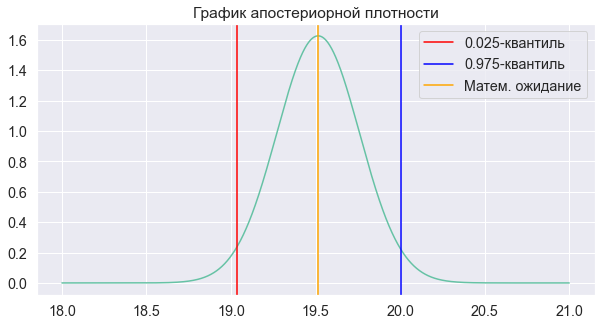

In [613]:
#построим график плотности с нужными параметрами и гистограмму
sns.set_style('darkgrid')

plt.figure(figsize=(10, 5))
plt.plot(t, density)
plt.axvline(x=quint_left, color='red', 
            label='{}-квантиль'.format('%.3f' %((1-alpha)/2)))
plt.axvline(x=quint_right, color='blue', 
            label='{}-квантиль'.format('%.3f' %((1+alpha)/2)))
plt.axvline(x=E, color='orange', 
            label='Матем. ожидание')
plt.legend()
plt.title('График апостериорной плотности');

Сделайте вывод о возможности применения метода Монте-Карло для нахождения константы апостериорного распределения. Какие преимущества и недостатки данного метода?

**Вывод:** Плюсы данного метода очевидны, это возможность взять нужный нам интеграл, когда аналитически мы не можем его взять, так же данный метод работает не оч медленно, но и не летает, это связано с тем, что ему приходится переумножать большое количество плотностей и довольно точно, но 1) его точность зависит от доп выборки (параметров доп распределения и количества) и 2)количества самих данных в нашей выборке. 

Сейчас подробно опишу каждый минус данного способа

1) Если мы возбмем неправильные параметры доп распределения, то мы можем получить совсем некорретные значения или вообще обнуление. Поэтому тут необходимо выбирать разумно нужное доп распределение. Также размер доп выборки влияет на точность, что важно, но не способно обнулить в случае правильности других вещей.

2) Самый огромный минус в том, что если посмотреть на его разряд, то это будет около $-40$ и это только при 178 числах выборки, соответственно если наша выборка будет размера ~1500 или больше, то у нас обнулится даже 2 способ (первый обнуляется намного раньше, писалось выше), таким образом даже при не оч большой выборке мы сталкиваемся с уже большими проблемами и обнулем в вычислении интеграла. 

Таким образом данный способ не способен (в такой реализации) работать с большими выборками+нам жизнено важен выбор параметра доп. распределения, иначе у нас произойдет обнуление даже при маленьком выборке(показывал в самом начале)

__________________
## Задача 2.

Рассмотрим схему испытаний Бернулли (т.е. броски монет) с вероятностью успеха $p$. 

**1)** Постройте несколько графиков сопряженного распределения для разных параметров и **охарактеризуйте**, как его значения параметров соотносятся с априорными знаниями о монете.
Можно рассмотреть следующие случаи.
* Монета скорее честная. Тогда наиболее вероятны значения $p$ в окрестности $0.5$.
* Монета скорее нечестная, перевес неизвестен. Тогда наименее вероятны значения $p$ в окрестности $0.5$.
* Монета скорее нечестная, перевес в сторону герба. Тогда наиболее вероятны значения $p$ в окрестности $1$.
* Монета скорее честная, либо с небольшим перекосом вправо. Тогда наиболее вероятны значения $p$ в окрестности $\approx 0.6$.
* Ничего не известно. Тогда все значния равновероятны.

Для каждого случая из перечисленных выше постройте график плотности сопряженного распределения (на одной фигуре).

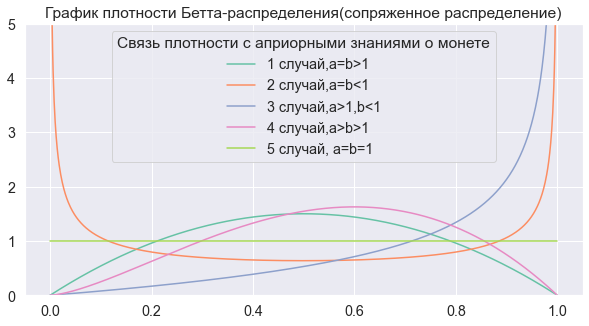

In [652]:
grid=np.linspace(0,1, 10**3)
plt.figure(figsize=(10, 5))

equil_1=1
less_1=1/2
more_1=2

plt.plot(grid, sps.beta.pdf(grid, more_1,more_1),label='1 случай,a=b>1')

plt.plot(grid, sps.beta.pdf(grid, less_1,less_1),label='2 случай,a=b<1')

plt.plot(grid, sps.beta.pdf(grid, more_1,less_1),label='3 случай,a>1,b<1')

plt.plot(grid, sps.beta.pdf(grid, more_1+0.5,more_1),label='4 случай,a>b>1')

plt.plot(grid, sps.beta.pdf(grid, equil_1,equil_1),label='5 случай, a=b=1')

plt.ylim(0,5)
plt.legend(title='Связь плотности с априорными знаниями о монете')
plt.title('График плотности Бетта-распределения(сопряженное распределение)');

**Вывод:** 

*1)*Монета скорее честная. Тогда наиболее вероятны значения $p$ в окрестности $0.5$.
Этот случай описывает beta при a=b>1, то есть у нас симметричная плотность должна быть. Чем выше показатели a,b тем выше будет горб плотности, тем выше будет вероятность равновероятного выпадания орла и решки.

*2)*Монета скорее нечестная, перевес неизвестен. Тогда наименее вероятны значения $p$ в окрестности $0.5$. Так как мы не знаем в какую сторону перевес, то симметрия все еще должна оставаться, то есть a=b. Но в данном случае a=b<1, тогда это будет симметричная выгнутая "чаша", у которой вероятность 0.5 наименьшая. Чем меньше a,b, тем более маленькое дно будет у чаши.

*3)*Монета скорее нечестная, перевес в сторону герба. Тогда наиболее вероятны значения $p$ в окрестности $1$. Нам сказали в какую сторону происходит перекос, в таком случае, есть два варианта. Это плотность, которая улетает в бесконечность при x=1 или холмик, несимметричный, который будет иметь пик около 1. Но так как тут открвоенно нечестная монета, то будем считать, что плотность будет возрастать при всех x, это достигается, когда a>1,b<1.

*4)*Монета скорее честная, либо с небольшим перекосом вправо. Тогда наиболее вероятны значения $p$ в окрестности $\approx 0.6$.
Вот тут должен быть уже несимметричный холмик, смешенный в одну(правую) сторону, описанный в прошлом пункте. Это будет происходить при a>b>1
*5)*Ничего не известно. Тогда все значния равновероятны.
Это известный случай, его описывает ситуация, когда a=b=1, тогда наш график будет совпадать с плотностью непрерывного равномерного распределения.

Ниже приведена реализация некоторых вспомогательных функций.

In [659]:
def draw_posteriori(grid, distr_class, post_params, xlim=None,ylim=None,status_legend=True,
                    title='Апостериорное распределение в зависимости от размера выборки'):
    '''
    Рисует серию графиков апостериорных плотностей.
    
    :param grid: сетка для построения графика
    :param distr_class: класс распределений из scipy.stats
    :param post_params: параметры апостериорных распределений 
        shape=(размер выборки, кол-во параметров)
    '''
    
    
    size = post_params.shape[0] - 1
    
    plt.figure(figsize=(12, 7))
    for n in range(size+1):
        plt.plot(grid, 
                 distr_class(post_params[n]).pdf(grid) \
                     if np.isscalar(post_params[n]) \
                     else distr_class(*post_params[n]).pdf(grid), 
                 label='n={}: {}'.format(n, np.round(post_params[n], 3)), 
                 lw=2.5,
                 color=(1-n/size, n/size, 0))
    plt.title(title)
    if status_legend==True:
        plt.legend()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    

def draw_estimations(ml, distr_class, post_params, confint=True, ylim=None,
                     title='Оценки параметра в зависимости от размера выборки',xlabel='Размер выборки',true_theta=None):
    '''
    Рисует графики байесовской оценки (м.о. и дов. инт.) и ОМП.
    
    :param ml: оценка максимального правдоподобия для 1 <= n <= len(sample)
    :param distr_class: класс распределений из scipy.stats
    :param post_params: параметры апостериорных распределений 
        shape=(размер выборки, кол-во параметров)
    '''
    
    size = len(ml)
    distrs = []
    for n in range(size+1): 
        distrs.append(distr_class(post_params[n]) \
                          if np.isscalar(post_params[n]) \
                          else distr_class(*post_params[n]))
    
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(size+1), [d.mean() for d in distrs], 
             label='Bayes', lw=2.5)
    plt.fill_between(np.arange(size+1), [d.ppf(0.975) for d in distrs], 
                     [d.ppf(0.025) for d in distrs], alpha=0.3)
    plt.plot(np.arange(size)+1, ml, label='MLE', lw=2.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    if true_theta!=None:
        plt.axhline(true_theta, color='red', label='Истинный параметр распределения={}'.format(true_theta))
    plt.legend()
    plt.show()

Реализуйте следующую функцию

Данную формулу мы выводили дома, поэтому просто напишу конечный результат $$beta(\alpha + \sum_{i=1}^n x_i,\, \beta + n - \sum_{i=1}^n x_i)$$

In [660]:
def bern_posterior_params(sample, a, b):
    '''
    Находит параметры апостериорного распределения 
        для всех 0 <= n <= len(sample). 
    
    :param sample: выборка
    :param a: параметр alpha априорного распределения
    :param b: параметр beta априорного распределения
    
    :returns: параметры апостериорного
    '''
    n=len(sample)
    sample_cumsum=np.cumsum(sample)
    first=a+sample_cumsum
    second=b+np.arange(1,n+1)-sample_cumsum
    res=np.stack((first, second), axis=-1)
    return np.insert(res,0,[a,b], axis=0)

**2)** Проведите по 15 бросков симметричной и несимметричной монет (можно сгенерировать) и рассмотрите для каждой из них два случая — параметры априорного распределения подобраны правильно или неправильно.
Постройте графики, воспользовавшись функциями `draw_posteriori` и `draw_estimations`.

In [661]:
grid=np.linspace(-20,20,10**5)
count=15
#Для начала давайте кидать симметричную монету
sample=sps.bernoulli(0.5).rvs(size=count)
sample

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0])

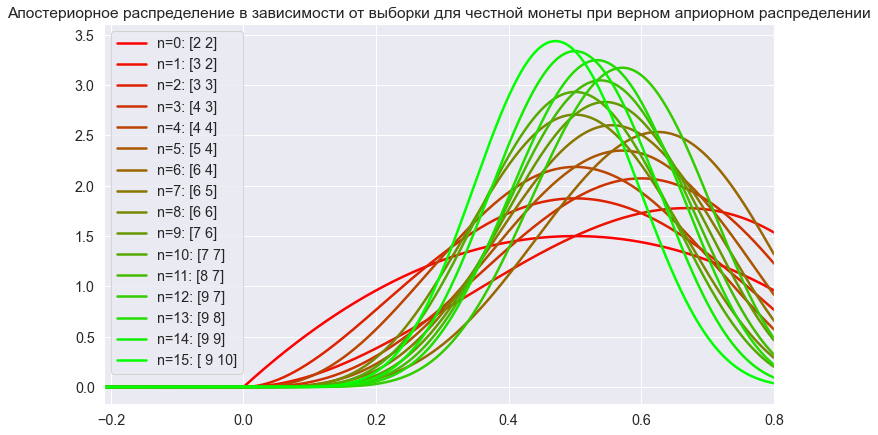

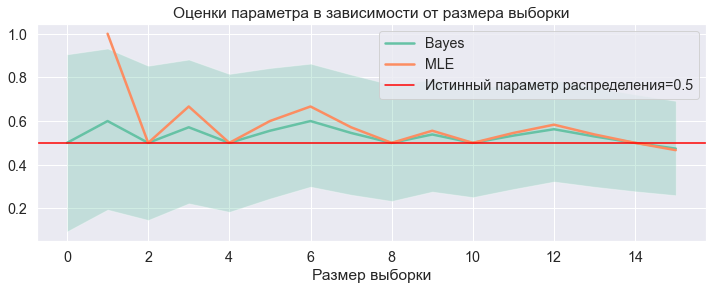

In [662]:
#рассмотрим две пары параметров априорного распределения (2,2)(верно) и (0.1,5)(неверно)
#с верным априорным
draw_posteriori(grid,sps.beta,bern_posterior_params(sample,2,2),xlim=(-0.21,0.8),
                title='Апостериорное распределение в зависимости от выборки для честной монеты при верном априорном распределении')
draw_estimations(np.cumsum(sample)/np.arange(1,count+1),sps.beta,bern_posterior_params(sample,2,2),true_theta=0.5)

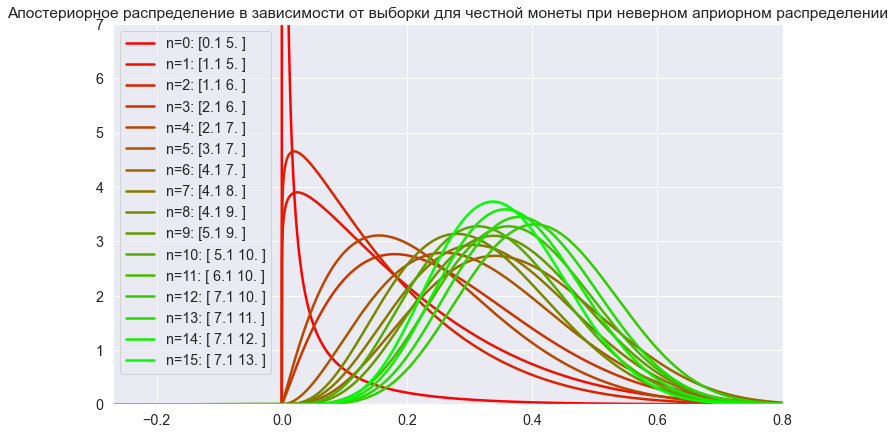

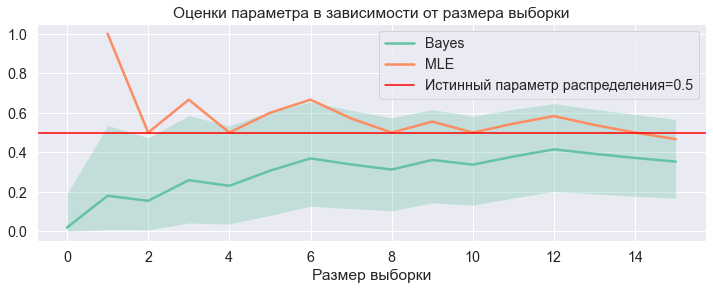

In [663]:
#с неверным априорным
draw_posteriori(grid,sps.beta,bern_posterior_params(sample,0.1,5),xlim=(-0.27,0.8),ylim=(0,7),
               title='Апостериорное распределение в зависимости от выборки для честной монеты при неверном априорном распределении')
draw_estimations(np.cumsum(sample)/np.arange(1,count+1),sps.beta,bern_posterior_params(sample,0.1,5),true_theta=0.5)

*Теперь сделаем аналогично, но когда у нас монета дико тяжелая с одной стороны (перевес в сторону герба. Тогда наиболее вероятны значения $p$ в окрестности $1$.)*

In [685]:
grid=np.linspace(-20,20,10**5)
count=15
#Для начала давайте кидать симметричную монету
sample=sps.bernoulli(0.9).rvs(size=count)
sample

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

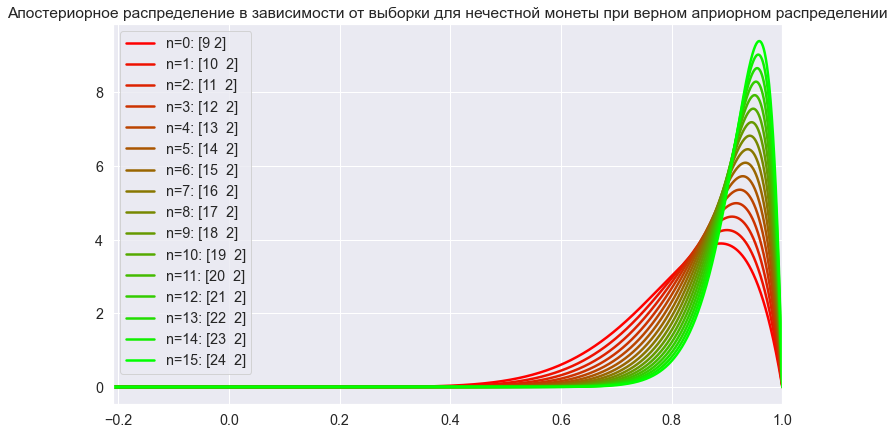

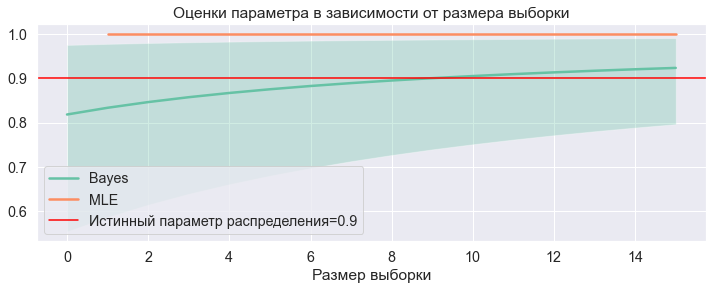

In [686]:
#рассмотрим две пары параметров априорного распределения (0.2,2)(верно) и (0.1,5)(неверно)
#с верным априорным
draw_posteriori(grid,sps.beta,bern_posterior_params(sample,9,2),xlim=(-0.21,1),
               title='Апостериорное распределение в зависимости от выборки для нечестной монеты при верном априорном распределении')
draw_estimations(np.cumsum(sample)/np.arange(1,count+1),sps.beta,bern_posterior_params(sample,9,2),true_theta=0.9)

C:\Users\Vova\anaconda3\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


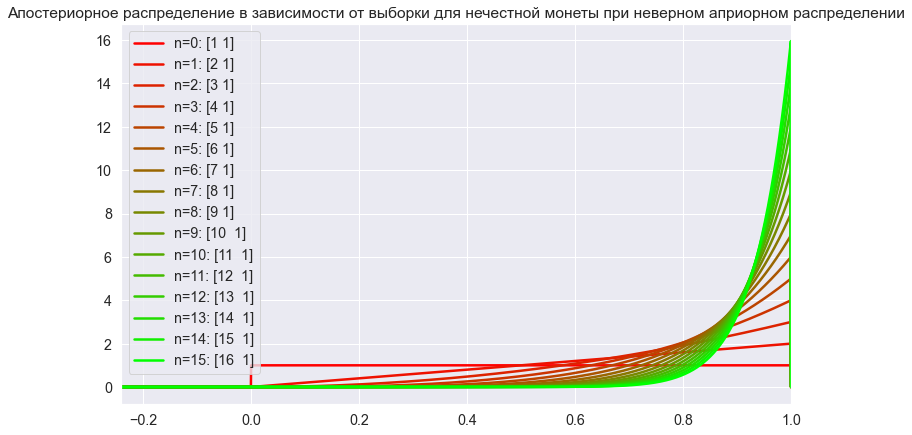

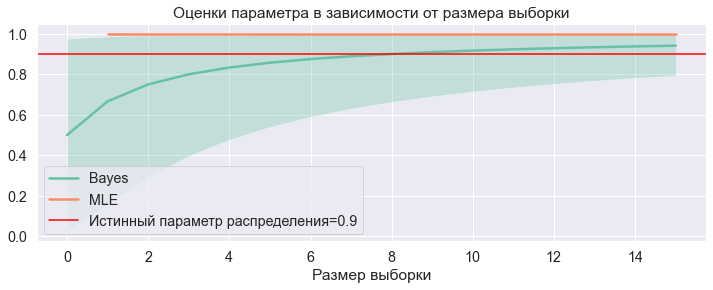

In [687]:
draw_posteriori(grid,sps.beta,bern_posterior_params(sample,1,1),xlim=(-0.24,1),
               title='Апостериорное распределение в зависимости от выборки для нечестной монеты при неверном априорном распределении')
draw_estimations(np.cumsum(sample)/np.arange(1,count+1),sps.beta,bern_posterior_params(sample,1,1),true_theta=0.9)

Сделайте вывод. Что можно сказать про зависимость от параметров априорного распределения? Сравните байесовские оценки с оценкой максимального правдоподобия параметра $p$. 

**Вывод:** Для каждого случая мы строили по 2 графика (график оценки и график апостериорного распределения). Давайте начнем сначала говорить про график апостериорного распределения. На самом деле он оч наглядный и дает нам много дополнительной информации.(например если будет итоговое распределение иметь несколько экстремумов, то мы сможем это увидеть) Мы видим каждый раз какое распределение получается при увеличении размера выборки, причем мы видим, как именно влияет выборка на него и как влияет наше начальное априорное распр. Но если мы построим на формулу параметров апостериорного распределения, то мы увидим, что начальные параметры с увеличением выборки уменьшают свое влияние на апост. распределение, так как их размер все меньшей вес каждый раз имеет.

Давайте сравним теперь MLE оценку и байесовскую оценку. 

Сначала посмотрим на первые две пары графиков(когда у нас правильная монетка). Если у нас задается правильное априорное, то тогда байес. оценка сходится быстрек к истинному значению, также так как байес. оценка содержит информацию о нашем первоначальном приблибжении, то тогда если MLE стремится к другому значению(неудачная генерация выборки или маленькая выборка), то байес. оценка будет "сопротивляться", так как в ней заложено, что первоначальные данные другие. 

Если у нас неправильное априорное, то тогда с ростом выборки оно будет стремиться к истинному значению, но оно будет "нехотя" стремиться и более медленно, чем MLE, так как будет учитывать наши первоначальные неправильные идеи, но при большом количестве выборки оно сойдется к истинному

*Смотрим на неправильную монету теперь*

На первом графике, когда у нас правильная априорная вероятность, ВИДЕН большой плюс байес. оценки, а именно, наша выборка плохо характеризует свой параметр (слишком мало измерений), MLE=1, хотя истинный 0.9. Но из-за того, что мы задали правильное априорное(причем не оч точно, так как мы указали 0.8), то это дало нам почти верную оценку, оч близкую к истинной, хотя MLE крайне сильно отличается.

На втором графике наше априорное нереально сильно отличается от истинного, но тут же как в случае и с правильной монетой, байес. оценка потихоньку стремиться к истинной (нанмого медленее MLE), но по итоге оно более близко к истинному значению. 

По итогу мы получаем, что на байес. оценку выборка влияет сильней, чем начальные параметры, но при этом они все продолжают тянуть ее к другому значению (уменьшают скорость сходимости) к оценку по самой выборке, в случае неправильной априорной, мы получаем более медленную сходимость, но при большой выборке, все равно будет стремиться к MLE, если же у нас правильная априорная, то мы стремимся к истинному даже в случаях, когда MLE вообще показывает не истинный параметр или когда у нас большие выбросы при маленьком размере выборки, то байес. оценка остается около истинного значени, так как она помнит о ней всегда)

__________________
## Задача 3.
 
В заключение вам предлагается творческая задача. Один экзаменатор на экзамене по математической статистике при выставлении оценки студенту пользуется следующей схемой. В течении экзамена экзаменатор задает студенту некоторое количество вопросов, получая тем самым выборку $X_1, ..., X_n \sim Bern(p)$ — индикаторы того, что студент на вопрос ответил правильно.
При этом сначала он подбирает некоторое априорное распределение на основе его знаний о студенте к моменту начала ответа. После каждого ответа студента экзаменатор вычисляет апостериорное распределение и строит байесовский доверительный интервал для $p$ уровня доверия 0.95. Если после очередного ответа студента доверительный интервал содержит лишь одно число $i/10$, где $i \in \{0, ..., 10\}$, то экзаменатор выставляет студенту оценку $\min(i+1, 10)$.

Ответьте на следующие вопросы:
* Квантили какого уровня нужно выбирать экзаменатору при построении доверительного интервала, чтобы задавать студенту как можно меньше вопросов? Какие оценки будет выставлять экзаменатор в таком случае?
* Как зависит оценка студента и среднее количество заданных вопросов у различных студентов (по уровню знаний) при различных априорных представлений экзаметора?
* Нужно ли дружить с таким экзаменатором?

Не ограничивайтесь только рассуждениями, не забывайте про визуализации.

   *Начнем*.Давайте начнем с общих рассуждений, давайте для простоты будем считать, что у нас есть три категории студентов: отличники, хорошисты, троечники. У первых шанс правильно ответить 80 процентов, у других 60, у других 30. Причем они учились весь семестр, и они смогли накопить БРС, именно по нему экзаменатор перед экзаменом будет строить первое впечатление о студенте. Очевидно, что БРС не всегда корректно отображает ситуацию, так как умный студент мог все проболеть и потерять много БРС, а троечник мог все скатать у халявного семинариста, так что у нас будут неправильные предположения встречаться. 

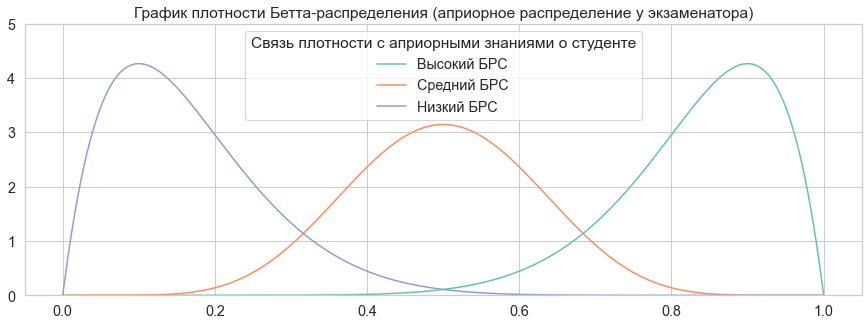

In [512]:
grid=np.linspace(0,1, 10**5)
plt.figure(figsize=(15, 5))


plt.plot(grid, sps.beta.pdf(grid, 10,2),label='Высокий БРС')

plt.plot(grid, sps.beta.pdf(grid, 8,8),label='Средний БРС')

plt.plot(grid, sps.beta.pdf(grid, 2,10),label='Низкий БРС')

plt.ylim(0,5)
plt.legend(title='Связь плотности с априорными знаниями о студенте')
plt.title('График плотности Бетта-распределения (априорное распределение у экзаменатора)');

In [594]:
#Запишем наши начальные данные
p_good=0.8
p_norm=0.6
p_bad=0.3
apri_good=[10,2]
apri_norm=[8,8]
apri_bad=[2,10]

Посмотрим на плотности сверху на графике, давайте заметим интересную вещь и **предложим идею насчет квантилей**-экзаменатору надо выбирать так квантиль, чтобы интеграл в области нашего квантиля был максимальным, то есть надо, чтобы границы квантилей смещались в нужную сторону.
То есть 1) a<b, тогда берем квантиль [0,95], 2)a=b, берем квантиль [0.025,0.975], a>b берем квантиль [0.05,1]. 
Давайте покажем это например для sps.beta.pdf(grid, a,b),1<a<b;

In [595]:
def draw_beta_and_quant(grid,a,b):
    res=cum_integral(sps.beta.pdf(grid, a,b),grid)
    
    quint_right_1=sps.beta(a,b).ppf(0.95)
    
    quint_left_1=sps.beta(a,b).ppf(0)
    
    quint_right_2=sps.beta(a,b).ppf(1)
    
    quint_left_2=sps.beta(a,b).ppf(1-0.95)

    
    plt.figure(figsize=(15, 5))

    plt.plot(grid, sps.beta.pdf(grid, a,b))
    plt.axvline(x=quint_left_1, color='red', 
                label='{}-квантиль'.format(0))
    plt.axvline(x=quint_right_1, color='red', 
                label='{}-квантиль'.format(0.95))

    plt.axvline(x=quint_left_2, color='blue', 
                label='{}-квантиль'.format(0.05))
    plt.axvline(x=quint_right_2, color='blue', 
                label='{}-квантиль'.format(1))
    plt.ylim(0,5)
    plt.legend()
    plt.title('График плотности Бетта-распределения с a={},b={}'.format(a,b));

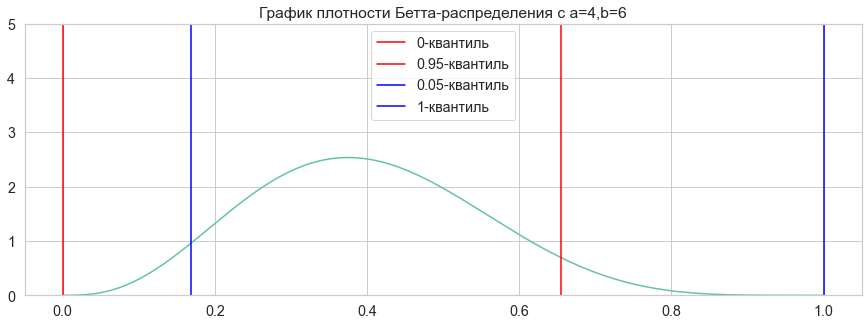

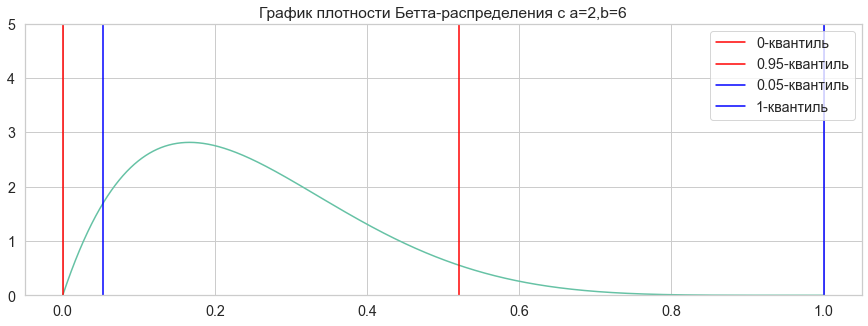

In [596]:
grid=np.linspace(0,1,10**5)
a,b=4,6
draw_beta_and_quant(grid,a,b)
a,b=2,6
draw_beta_and_quant(grid,a,b)

Хорошо видно, что из-за правого хвоста доверительный интервал построенный с помощью синих квантилей,будет затрагивать больше 0.i(i=0...10) (такой доверительный интервал более длинный по оси x), таким образом, экзамен будет идти более долго, а цель экзаменатора побыстрей отпустить студента. Теперь по-хорошему надо проверить еще на двух случаях, когда a<b<1, a<1<b, то там будут график, похожий на гиперболу, а в другом случае там будет "чаша", но там очевидна выгодность нашей стратегии.
Если же мы берем a=b, то у нас горб максимальный по центру, так как у нас симметрия, в таком случае тоже очевидна выгодость нашей тактики насчет квантилей.

**мини-итог насчет квантилей** То есть 1) a<b, тогда берем доверительный интервал,смещенный влево, 2)a=b, берем квантиль [0.025,0.975], a>b берем квантиль доверительный интервал,смещенный вправо. Изначально я собирался брать всего "радикальные" [0,95],[0.05,1], в таком случае это идеально будет работать для отличников (10) и людей на отчисление(1-2), но это не будет давать лучший результат, когда у нас крепкий троечник,хорошист, слабый отличник. Поэтому давайте реализуем подбор оптимального квантиля, но сделаем это через маленькую сетку, чтобы скорость алгоритма итогового не начала стремиться к 0.

Давайте теперь сгенерим все данные, то есть у нас есть 3 уровня подготовки к экзамену и 3 результата за работу во время семестра. Всего 9 комбинаций. Для каждой генерации сгенерим n данных. Для начала посчитаем для одного студента(затем сделаем для n), также мы будем считать, что максимум 200 вопросов за экзамен может задаваться

In [597]:
p_all=[p_good,p_norm,p_bad]
apri_all=[apri_good,apri_norm,apri_bad]
n=1
count=200
sample=[sps.bernoulli(p_good).rvs(size=(n,count)),sps.bernoulli(p_norm).rvs(size=(n,count)),
        sps.bernoulli(p_bad).rvs(size=(n,count))]

In [598]:
def search_opt_quint(a,b):
    left=np.linspace(0,0.05,10)
    quint_right=sps.beta(a,b).ppf(0.95+left)
    quint_left=sps.beta(a,b).ppf(left)
    diff=np.array(quint_right)-np.array(quint_left)
    index=diff.argmin()
    return (left[index])

In [599]:
title_pattern='Апостериорное распределение студента({}) с априорным впечатлением({})'
title=[]
for i in ['отл','хор','уд']:
    for j in ['отл','хор','уд']:
        title.append(title_pattern.format(i,j))

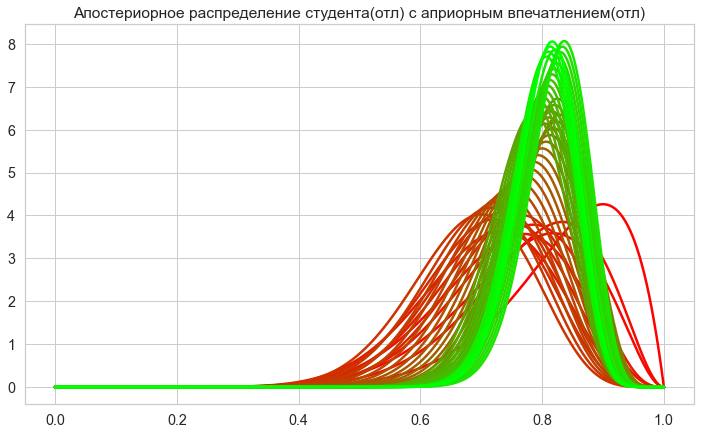

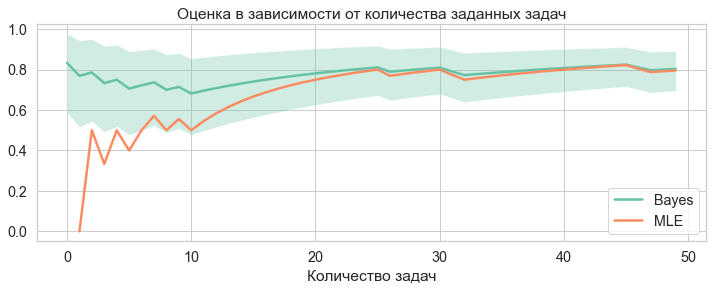

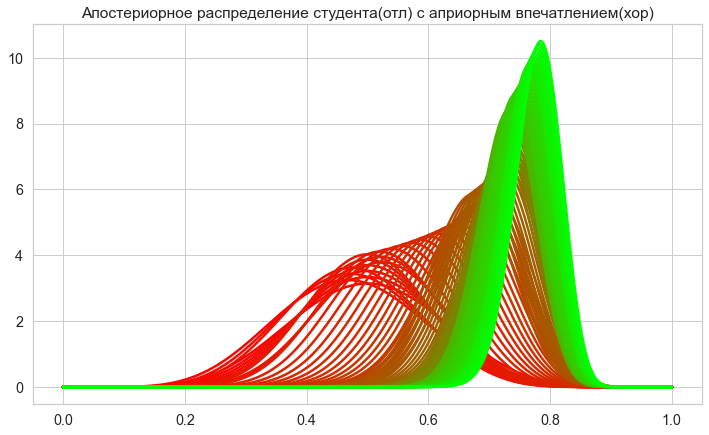

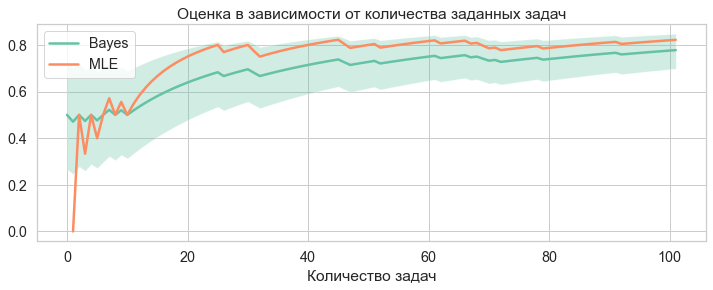

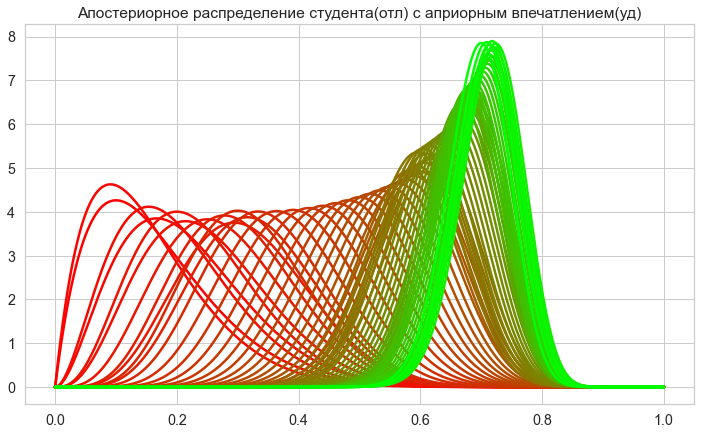

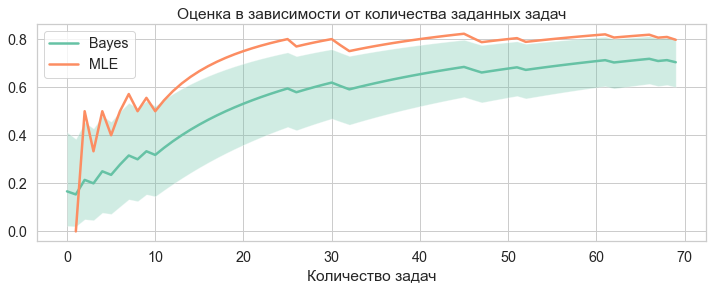

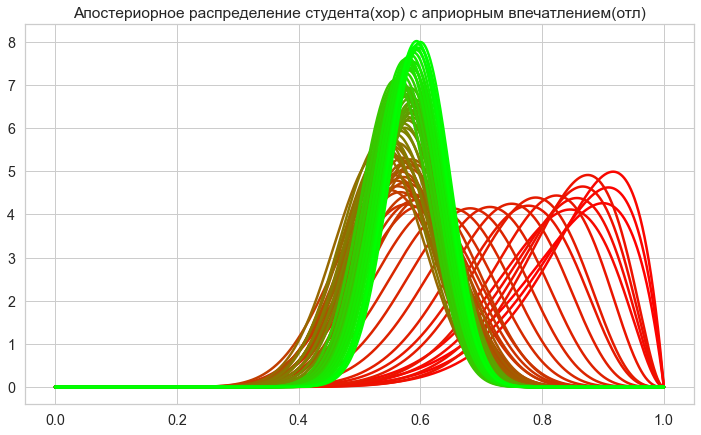

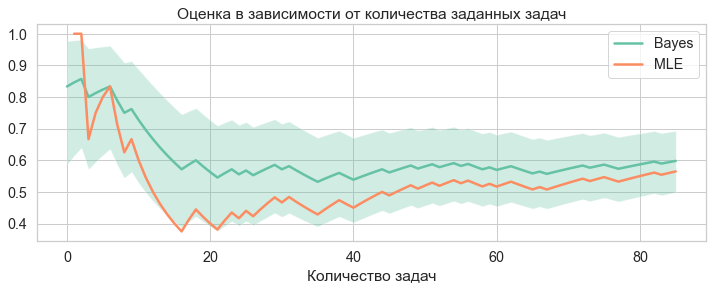

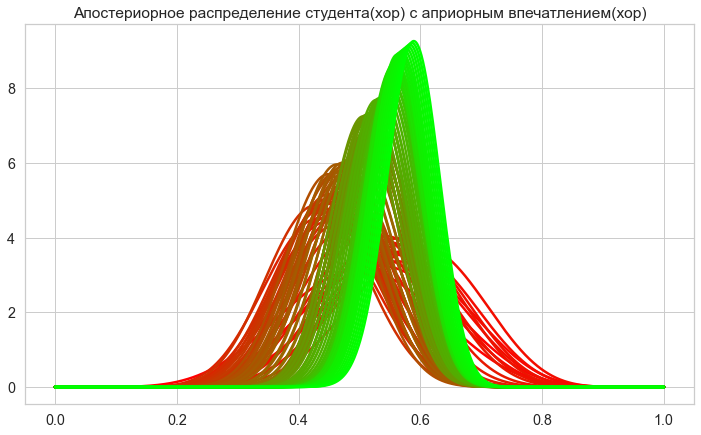

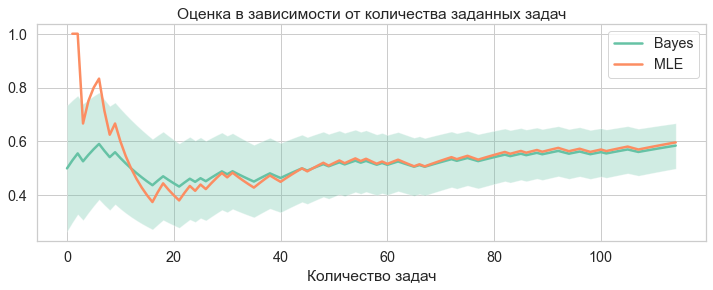

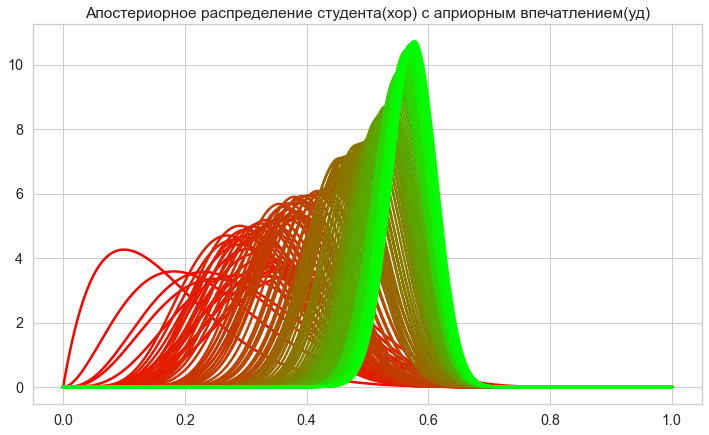

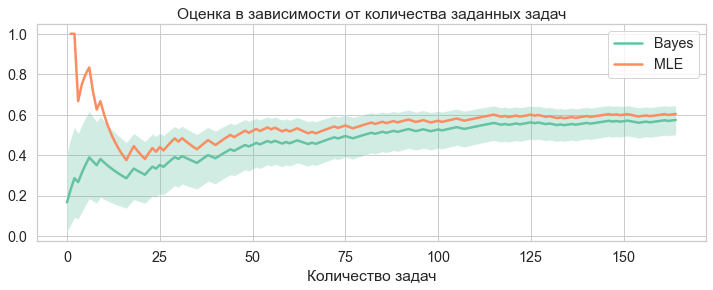

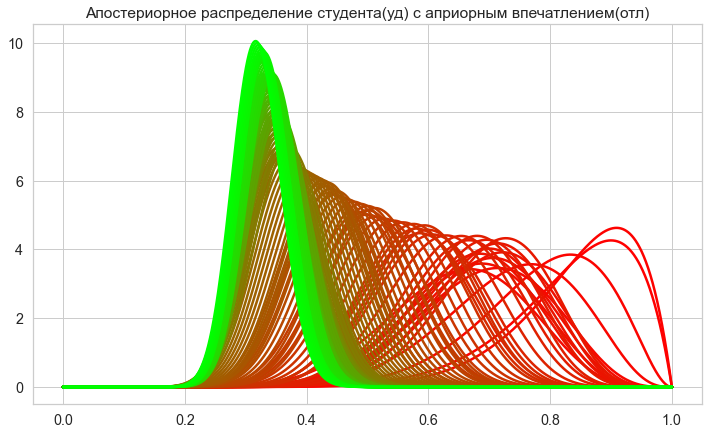

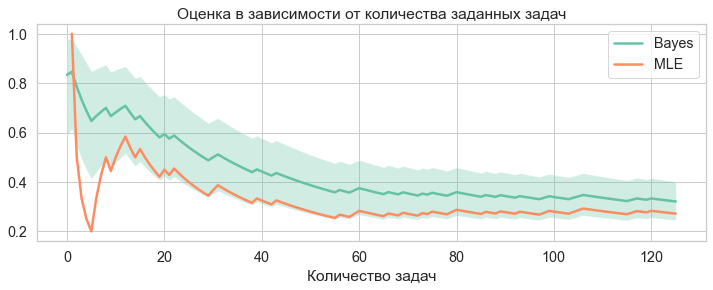

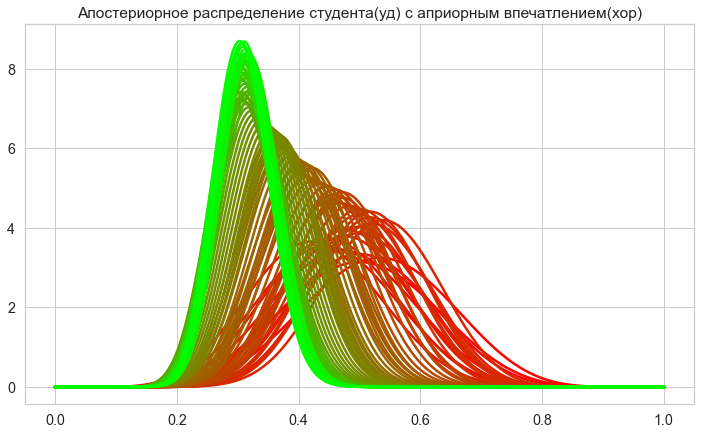

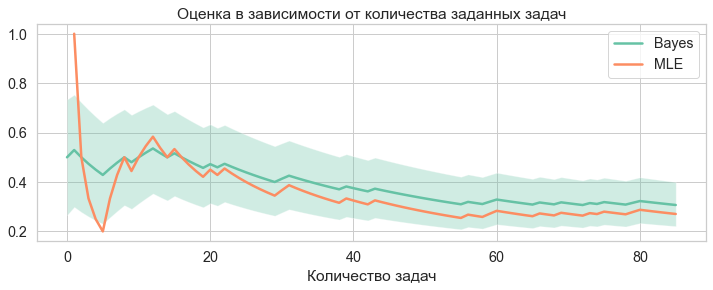

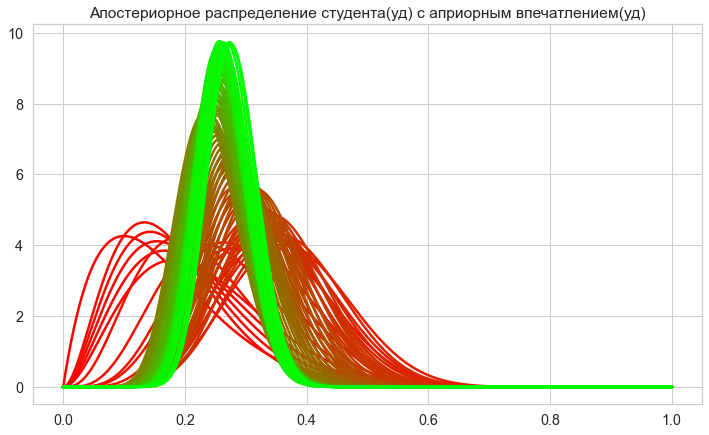

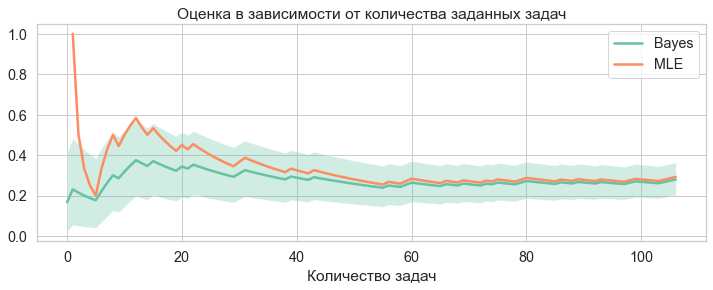

In [600]:
#начнем обработку данных 
counter=-1
for i,sample_i in enumerate(sample):
    for j,apri_j in enumerate(apri_all):
        counter+=1
        #ищем до какого вопроса его будут спрашивать
        index_stop=len(sample_i[0])
        post_params=bern_posterior_params(sample_i[0],apri_j[0],apri_j[1])
        for k in range(1,len(post_params)):
            #тут выбирается тактика экзаменатора после каждого ответа
            #еще к с 1, так как в post_params есть начальные данные, а студент сначала ответить должен
            a,b=post_params[k]
            left=search_opt_quint(a,b)
            quint_right=sps.beta(a,b).ppf(0.95+left)
            quint_left=sps.beta(a,b).ppf(left)
            
            quint_right=int(np.floor(10*quint_right))
            quint_left=int(np.ceil(10*quint_left))
            
            if (quint_left==quint_right):
                index_stop=k
                break
        draw_posteriori(grid,sps.beta,post_params[:index_stop+2],status_legend=False,title=title[counter])
        draw_estimations(np.cumsum(sample_i[0][:index_stop])/np.arange(1,index_stop+1),sps.beta,post_params[:index_stop+2],
                        xlabel='Количество задач', title='Оценка в зависимости от количества заданных задач')

Мы провели экзамен для 9 студентов, которые описывают все 9 возможных ситуаций. На графиках оценок хорошо видно, что экзамен довольно часто заканчивается до того, как пулл вопросов (200) заканчивается. Также прослеживается еще некоторая закономерность с оценками, но про нее мы скажем дальше.
Также есть важная зависимость между ситуацикй студента и количеством вопросов. Но сильно бросается в глаза, что независимо от первого впечатления о студенте, он все равно выводит его на чистую воду и ставит ту оценку за экзамен, на которую подготовилс студент. Хотя оценка все равно выше слегка, чем если бы брс не учитывался, просто вместо пересдачы или уд3, человек получает уд4.
*Давайте проведем испытание*, когда каждую ситуацию описывает 1000 детей и когда у нас бесконечный пулл вопросов(интересно посмотреть, что произойдет в такой ситуации) и сделаем уже окончательный вывод

In [601]:
n=1000
count=10**3
sample=[sps.bernoulli(p_good).rvs(size=(n,count)),sps.bernoulli(p_norm).rvs(size=(n,count)),
        sps.bernoulli(p_bad).rvs(size=(n,count))]

In [602]:
#начнем обработку данных 
assessment=[[[],[],[]],[[],[],[]],[[],[],[]]]
count_questions=[[[],[],[]],[[],[],[]],[[],[],[]]]
for i,sample_category in tqdm(enumerate(sample)):
    for j,apri_j in (enumerate(apri_all)):
        #ищем до какого вопроса его будут спрашивать
        for  sample_i in tqdm(sample_category):            
            post_params=bern_posterior_params(sample_i,apri_j[0],apri_j[1])
            index_stop=len(sample_i)
            res_assessment=sps.beta(post_params[index_stop][0],post_params[index_stop][1]).mean()
            
            for k in range(1,len(post_params)):
                #тут выбирается тактика экзаменатора после каждого ответа
                #еще к с 1, так как в post_params есть начальные данные, а студент сначала ответить должен
                a,b=post_params[k]
                left=search_opt_quint(a,b)
                quint_right=sps.beta(a,b).ppf(0.95+left)
                quint_left=sps.beta(a,b).ppf(left)

                quint_right=int(np.floor(10*quint_right))
                quint_left=int(np.ceil(10*quint_left))

                if (quint_left==quint_right):
                    index_stop=k
                    res_assessment=(min(10,1+quint_left))
                    break
                
            assessment[i][j].append(res_assessment)
            count_questions[i][j].append(index_stop)
            

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [694]:
title_pattern=' у студента({}) с априорным впечатлением({})'
title=[]
for i in ['отл','хор','уд']:
    for j in ['отл','хор','уд']:
        title.append(title_pattern.format(i,j))

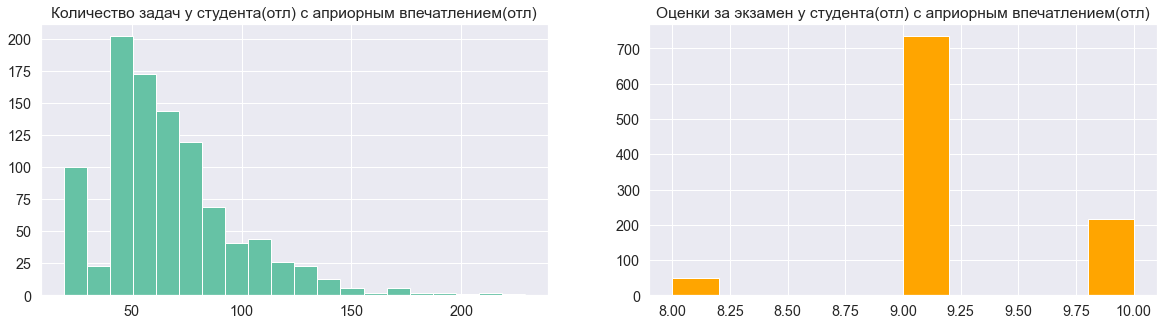

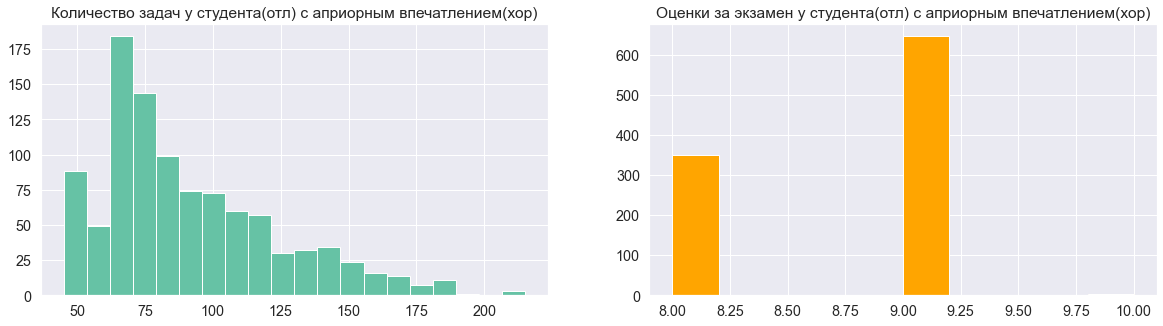

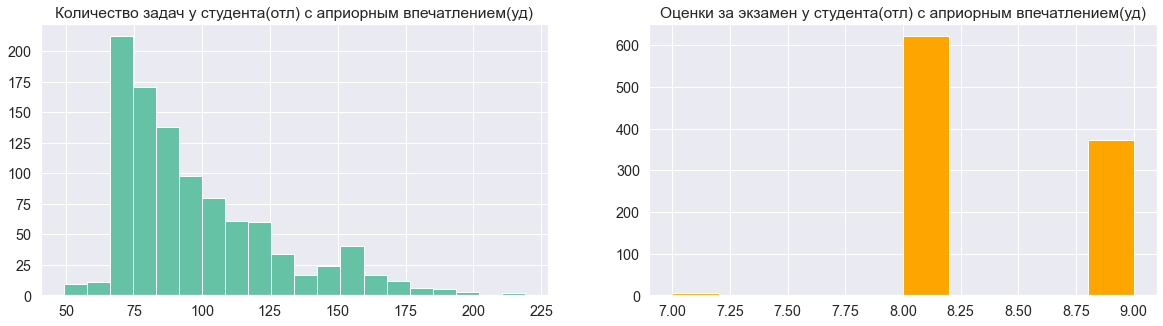

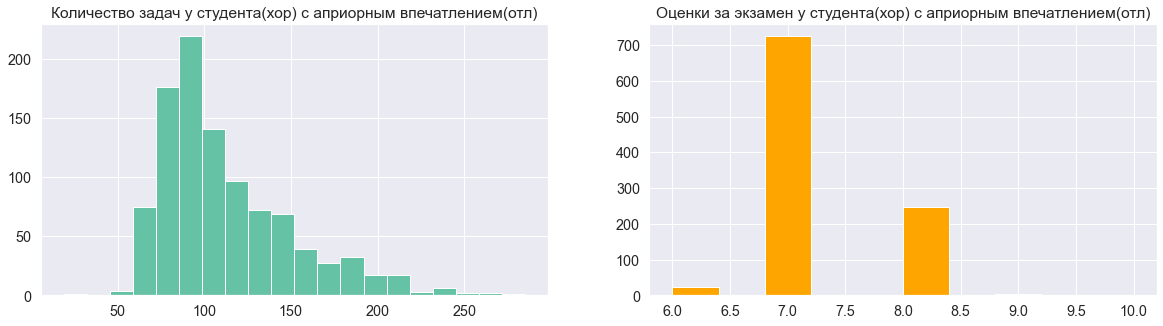

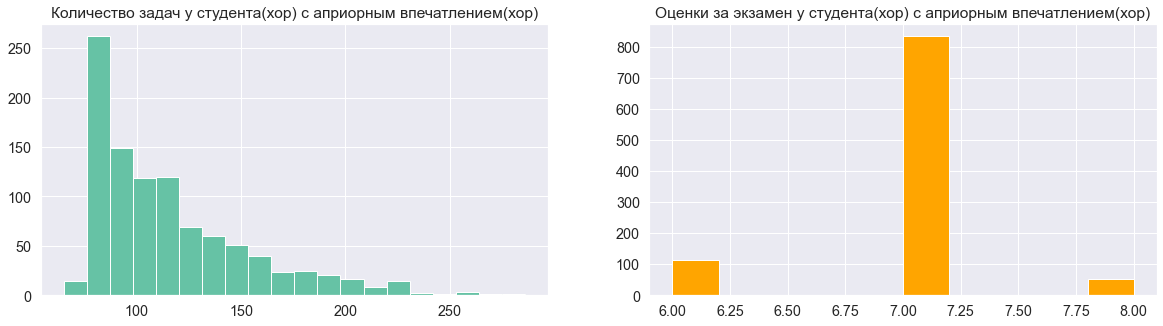

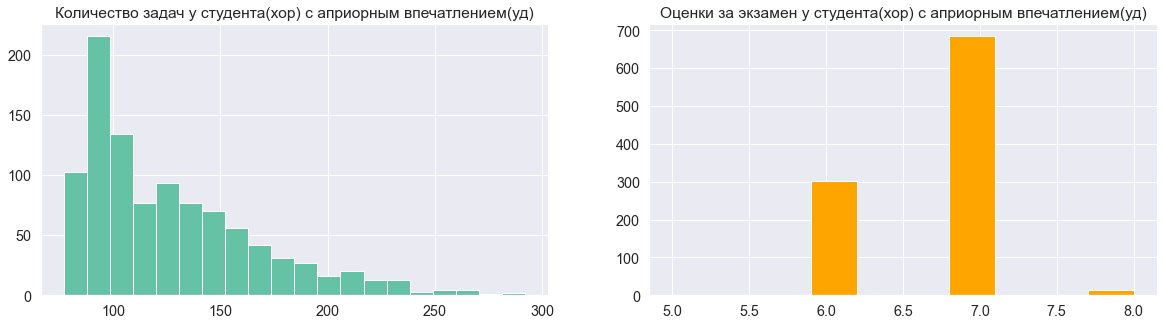

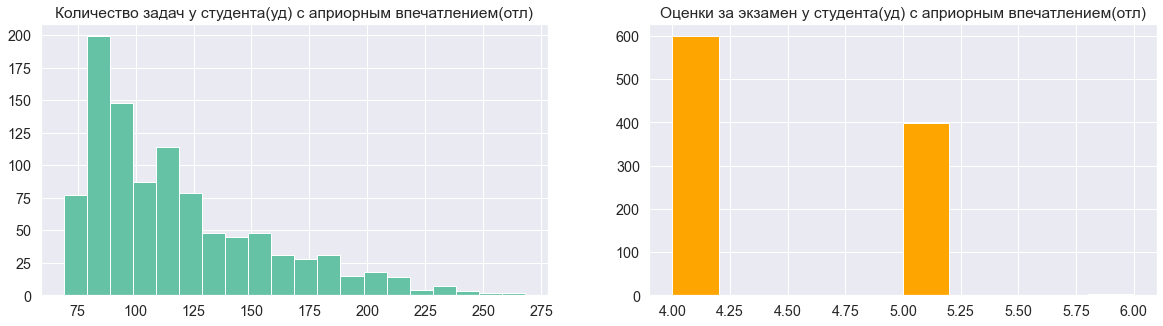

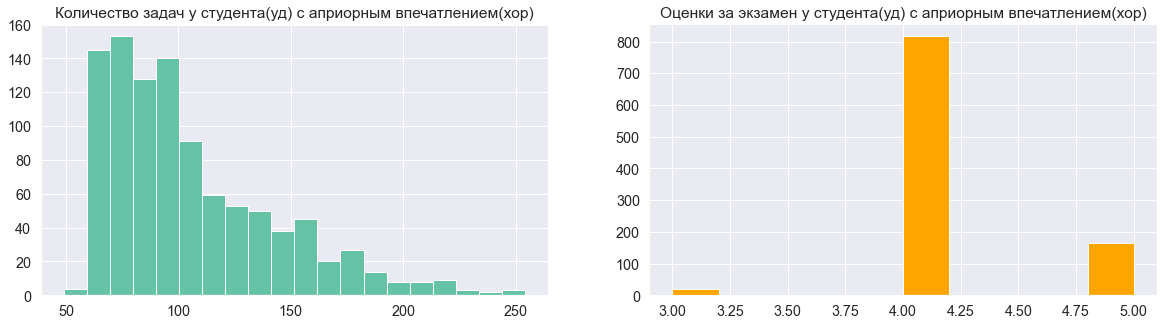

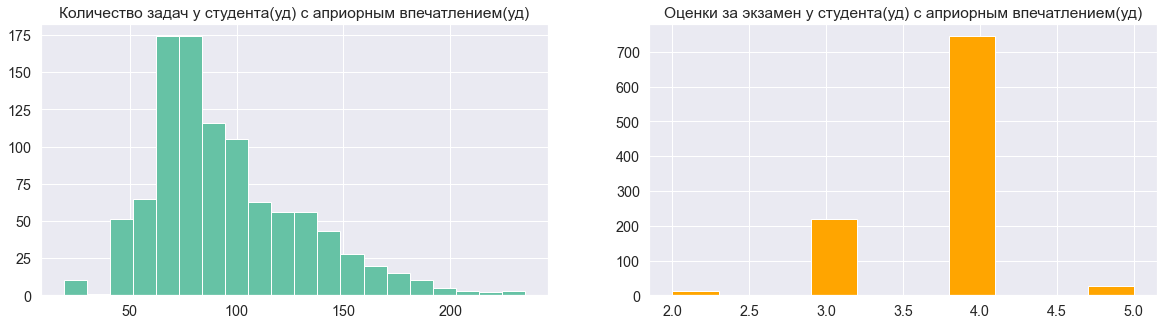

In [696]:
#Давайте для каждой категории построим гистограмму количества задача и итоговую оценку
counter=-1
for i in range(len(count_questions)):
    for j in range(len(count_questions[i])):
        counter+=1
        fig,axs = plt.subplots(1, 2,figsize=(20,5))

        
        axs[0].hist(count_questions[i][j],bins=20)
        axs[0].set_title("Количество задач"+title[counter])

        axs[1].hist(assessment[i][j], color='orange')
        axs[1].set_title("Оценки за экзамен"+title[counter])

**Вывод:** 
1)Если человек знает на отл, то чем лучше первое впечатление(БРС), тем меньше экзаменатор будет его гонять. Он все равно получит отл, но чем хуже БРС, тем больше вероятность, что он получит 8, а не 9 и 10(10 получают вообще только те у кого брс на отл)

2) Если у человека хор, то он скорее всего получит хор, но есть шанс на отл. То есть если брс на отл, то будет или хор 7 или отл 8. Если же брс на хор, то будет скорее всего средний хор 7(есть шанс побадаться за отл 8). Если же брс на уд, то он получит хор, но шансы на отл 8 почти теряет.

3) Если же перед нами троечник, но имеет брс на отл, то он может получить хор 5, хотя скорее всего получит уд4, но шансы на хор 5 хорошие. Если же брс на хор, то выше уда он не получит, но пересдачу не получит и получит уд 4 с большой вероятностью.Если же брс на уд, то уже появляется шанс на пересдачу, шанс на уд 4 снижается, а на уд только растет.

Вывод, экзаменатор нормальный, не халява, но и не фачит, а ставит довольно заслуженно, причем дает возможность бороться за более высокую оценку, даже если ты имеешь брс и знания слегка меньше, но ты долэжен показаьть себя